# Использование предобученных моделей

Задание: собрать датасет и использовать перенос обучения для решения задачи классификации.

## Порядок выполнения

1. Скачать изображения для создания датасета. Как структурировать папки подсмотрите в работе по ConvNet в датасете с Симпсонами;
1. Подготовить transforms, DataSet и DataLoader;
1. Выбрать одну из моделей в библиотеке timm;
1. Использовать на этой модели прием выделения признаков;
1. Использовать на этой модели прием дообучения (fine-tune);
1. Оценить результаты лучшей модели на тестовой выборке.

## Источники

1. [Туториал от Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
1. [GitHub pytorch-image-models](https://github.com/huggingface/pytorch-image-models)
1. [Извлечение признаков](https://huggingface.co/docs/timm/feature_extraction)
1. [Which image models are best?](https://www.kaggle.com/code/jhoward/which-image-models-are-best)
1. [Pytorch Image Models (timm)](https://timm.fast.ai/)
1. [huggingface docs timm](https://huggingface.co/docs/hub/timm)

## Создание датасета

В этом задании вам надо собрать собственный датасет из изображений. В нем должно быть минимум 30 изображений для каждого класса. Количество классов не менее 2. Тематику датасета вы выбираете самостоятельно.

Далее в этом разделе приведен пример кода, который помогает скачать изображения по запросу на гугл диск. Вы можете решить эту задачу другими удобными для вас способами, в том числе и вручную.

Если вы работаете с локальной средой, то код из примера придется модифицировать.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import timm

import random


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2


In [110]:
# import os
# def create_folder_structure(base_path, classes):
#     """Создает структуру папок для датасета."""
#     for cls in classes:
#         os.makedirs(os.path.join(base_path, 'train', cls), exist_ok=True)

# def download_images(class_name, output_folder, num_images):
#     """Скачивает изображения для указанного класса."""
#     with DDGS() as ddgs:
#         ddgs_images_gen = ddgs.images(
#             class_name,
#             region="wt-wt",
#             size="Medium",
#             type_image="photo",
#             max_results=num_images
#         )
        
#         for idx, image_data in enumerate(tqdm(ddgs_images_gen, total=num_images, desc=f"Downloading {class_name}")):
#             image_url = image_data['image']
#             try:
#                 response = requests.get(image_url, timeout=10)
#                 response.raise_for_status()

#                 # Сохраняем изображение
#                 image_path = os.path.join(output_folder, f"{class_name}_{idx+1}.jpg")
#                 with open(image_path, 'wb') as f:
#                     f.write(response.content)
#             except Exception as e:
#                 print(f"Failed to download {image_url}: {e}")

# # Параметры
# classes = ["автомобиль", "мотоцикл", "автобус", "грузовик"]
# base_path = "dataset"
# num_images_per_class = 150 

# # Создаем структуру папок
# create_folder_structure(base_path, classes)

# # Скачиваем изображения
# for cls in classes:
#     train_folder = os.path.join(base_path, 'train', cls)
#     download_images(cls, train_folder, num_images_per_class)

# print("Загрузка изображений завершена.")

### Ответы по датасету (макс. 20 баллов)

В результате работы по этому разделу у вас должен получиться датасет. Проверьте что все скачанные изображения открываются и удалите поврежденные файлы. Изображения стоит разделить в папках на train и test и примерном соотношении 80 и 20%.

Доступ к вашему датасету потребуется открыть. Если вы скачивали изображения локально, то их надо будет выгрузить на гугл или яндекс диск.

**Ссылка на ваш датасет -https://drive.google.com/file/d/1GqMbUVzEOKNnFRUf64yPtyU462OiKpeM/view?usp=sharing

**Описание вашего датасета:**

* Общее описание решаемой задачи:
* Количество классов:
* Имена классов:
* Количество изображений в каждом классе в обучающей и тестовой выборках

---

Ваш ответ:

## Импортирование модулей

In [3]:
# Использование GPU по желанию

if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Работаем на GPU')
else:
  device = torch.device('cpu')
  print('Работаем на CPU')


Работаем на GPU


## Выбор модели из timm

В источниках к заданию, вы найдете список моделей, который выложен на github и [сравнение части моделей из timm](https://www.kaggle.com/code/jhoward/which-image-models-are-best). Вам необходимо остановить свой выбор на одной из них. В списке моделей на github есть ссылки на статьи о них, где можно найти информацию на каком датасете они были обучены.

Если вы работаете с фотографиями выбор можно остановить на одной из:
1. MobileNet,
1. VGG,
1. ResNet,
1. Xception.

По желанию можете попробовать несколько и сравнить.


In [112]:
# вывод списка моделей содержащих *resnet* и предобученных
timm.list_models("*resnet*", pretrained=True)


['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet18d.ra4

In [113]:
# Выбор модели из timm
model_name = "resnet50"  # Выбранная модель
pretrained_model = timm.create_model(model_name, pretrained=True)

# Проверка архитектуры модели
print(pretrained_model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

В описании архитектуры модели в выводе предыдущей ячейки, найдите два новых модуля (Conv2d, ReLU вы уже знаете) и добавьте их описание. (макс. 15 баллов)

**Ваш ответ:**

1. Модуль ___ - делает ...
1. Модуль ___ - делает ...

**Почему решили выбрать именно эту модель?** (макс. 5 баллов)

Ваш ответ:

## Создание Dataset и DataLoader

По аналогии с прошлыми заданиями нам требуется создать transforms, которые передаются в создаваемый Dataset и из датасета вы создаете DataLoaders.

Данных у нас немного, поэтому мы не будем выделять валидационную часть.

При создании transforms помните, что модель ожидает на вход тензор определенной размерности. В [описание моделей](https://paperswithcode.com/lib/timm), вы можете найти датасет, на котором обучалась модель и есть описание размера изображений.

Для работы вам пригодится:

- v2.ToImage()
- v2.Resize() или v2.RandomResizedCrop() - размер изображения после кадрирования, должен быть равен размеру ожидаемому на ходе предобученной модели.
- v2.RandomRotation()
- v2.RandomHorizontalFlip()
- v2.ToDtype()

[Описания в документации](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

In [114]:
## чистим битые файлы!


def clean_dataset(dataset_path):
    """Удаляет поврежденные изображения из указанного пути."""
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Проверяет, можно ли открыть файл
            except (IOError, SyntaxError):
                print(f"Удаление поврежденного файла: {file_path}")
                os.remove(file_path)

# Очистка датасета
clean_dataset("dataset/train")


In [115]:

base_path = "dataset"
transforms_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создаем Dataset
full_dataset = ImageFolder(root=os.path.join(base_path, 'train'), transform=transforms_pipeline)

# Разделение на train и test (80% / 20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Создаем DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Данные разделены и подготовлены.")



Данные разделены и подготовлены.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping inpu

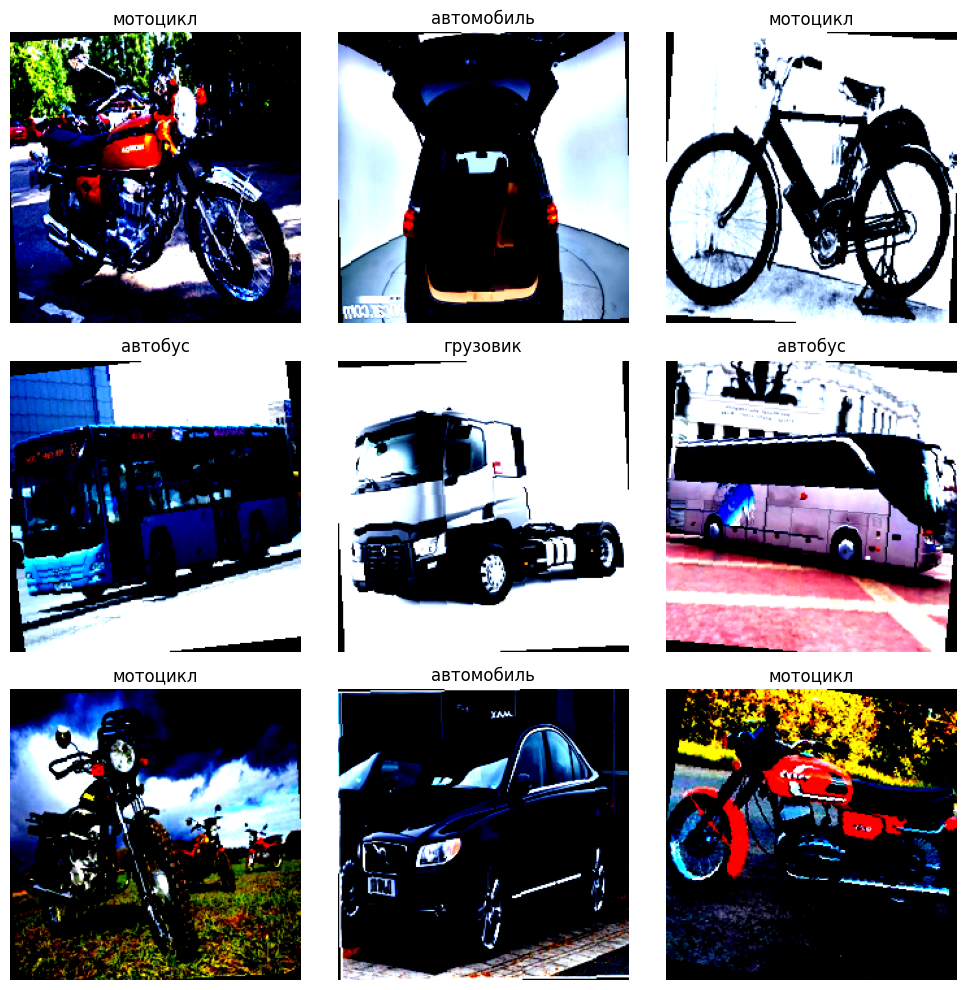

In [116]:

# Выбираем случайные индексы для 9 изображений
indices = random.sample(range(len(train_dataset)), 9)

# Создаем фигуру для отображения
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Отображаем 9 изображений
for i, ax in enumerate(axes.flatten()):
    # Извлекаем изображение и класс
    img, label = train_dataset[i]  # используем индексы для выборки данных
    
    # Отображаем изображение
    ax.imshow(img.permute(1, 2, 0))  # Переставляем оси для отображения
    ax.axis('off')  # Отключаем оси

    # Подпись с названием класса (используем dataset.classes для получения классов)
    ax.set_title(train_dataset.dataset.classes[label])

# Отображаем все изображения
plt.tight_layout()
plt.show()


**Почему выбрали именно такие преобразования (transforms) для данных?** (макс. 10 баллов)

Ваш ответ:
Выбранные преобразования (resize, random rotation, horizontal flip, normalization) обеспечивают унификацию размеров изображений, а также добавляют вариативность данных, что помогает модели лучше обобщать. Нормализация адаптирует данные к статистике предобученной модели. Эти трансформации особенно полезны для небольших датасетов.

## Прием извлечения признаков

Этот прием может использоваться как сам по себе, так и быть предварительным этапом для дообучения.

Он заключается в том, что мы заменяем полносвязную часть модели (head/голову) на свою с учетом размерностей выходных данных из сверточной части и количеством классов в текущей задаче. Перед обучением требуется "заморозить" параметры сверточных слоев.

**Почему требуется "заморозка" параметров?** (макс. 10 баллов)

Ваш ответ:

"Заморозка" параметров позволяет сохранить уже обученные базовые признаки предобученной модели, избегая их изменения. Это снижает риск переобучения, ускоряет обучение и позволяет адаптировать модель к новому датасету, обучая только классификационную "голову".

У модели вы можете использовать метод .parameters(), он возвращает итерируемый объект с параметрами вашей модели. Вы можете их перебрать и отключить необходимость расчета градиентов.

In [117]:
# "Замораживаем" веса
# for param in ___:
    #param...

# Заменяем "голову"
# .fc для вашей модели может иметь другое имя
# В nn.Sequential добавьте 1-2 скрытых слоя (nn.Linear, nn.ReLU)
# pretrained_model.fc = nn.Sequential()


# Замораживание слоев
for param in pretrained_model.parameters():
    param.requires_grad = False
classes = ["автомобиль", "мотоцикл", "автобус", "грузовик"]
# Замена "головы" модели
num_classes = len(classes)  # Количество классов в задаче классификации
pretrained_model.fc = torch.nn.Sequential(
    torch.nn.Linear(pretrained_model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(512, num_classes)
)

print("Модель подготовлена.")

Модель подготовлена.


In [118]:
# Подготовка для обучения
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

В этой работе также рассмотрим применение планировщика для изменения скорости обучения. Ранее у вас скорость обучения была константой, теперь же в процессе обучения каждые n эпох будем ее снижать.



In [119]:
from torch.optim import lr_scheduler

# Добавляем планировщик скорости обучения
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # Каждые 3 эпохи lr уменьшается в 10 раз


### Обучение и тестирование

Несколько эпох обучите модель в таком состоянии. Для обучения используйте уже знакомый вам цикл с эпохами и перебором dataloader, но к нему в цикл эпох требуется добавить шаг планировщика scheduler.step().

Не забывайте переключать режимы моделей (pretrained_model.train(), pretrained_model.eval()), так как теперь в них может быть пакетная нормализация и используйте контекст torch.no_grad() при проверке модели.

In [120]:

pretrained_model = pretrained_model.to(device)

# Параметры обучения
num_epochs = 10

# Цикл обучения
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    pretrained_model.train()  # Устанавливаем режим тренировки
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = pretrained_model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Training loss: {running_loss / len(train_loader)}")

    # Оценка на тестовой выборке
    pretrained_model.eval()  # Устанавливаем режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

    # Шаг изменения скорости обучения
    scheduler.step()

print("Обучение завершено.")

Epoch 1/10


c:\workV\.МАГА\3сем\РО\LAB5\MLOps\.venv\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training loss: 1.121227593421936
Test Accuracy: 75.00%
Epoch 2/10
Training loss: 0.7244043457508087
Test Accuracy: 73.00%
Epoch 3/10
Training loss: 0.5240118670463562
Test Accuracy: 76.00%
Epoch 4/10
Training loss: 0.49005705773830416
Test Accuracy: 75.00%
Epoch 5/10
Training loss: 0.4422713714838028
Test Accuracy: 78.00%
Epoch 6/10
Training loss: 0.4249668711423874
Test Accuracy: 76.00%
Epoch 7/10
Training loss: 0.4077900582551956
Test Accuracy: 77.00%
Epoch 8/10
Training loss: 0.3993350428342819
Test Accuracy: 80.00%
Epoch 9/10
Training loss: 0.422112495303154
Test Accuracy: 76.00%
Epoch 10/10
Training loss: 0.3808488965034485
Test Accuracy: 75.00%
Обучение завершено.


## Прием дообучения

Чтобы дообучить модель, требуется разморозить параметры модели. Для упрощения можете разморозить все параметры модели, но более правильно будет разморозить параметры 1-2 последних слоев и оптимизировать их, и наиболее сложный вариант разморозить больше 2 слоев, но использовать сниженные скорости обучения для более ранних слоев модели - [TORCH.OPTIM](https://pytorch.org/docs/stable/optim.html#per-parameter-options).

In [121]:
loss_fn = torch.nn.CrossEntropyLoss()

# Новый оптимизатор, включающий все параметры модели
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.0001)

# Планировщик для изменения скорости обучения
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [122]:
# Разморозка всех параметров модели
for param in pretrained_model.parameters():
    param.requires_grad = True

# Альтернативно: разморозить только последние слои
# for param in pretrained_model.layer4.parameters():
#     param.requires_grad = True


# Цикл дообучения
num_epochs = 5  # Количество эпох для дообучения
for epoch in range(num_epochs):
    print(f"Fine-Tuning Epoch {epoch + 1}/{num_epochs}")
    pretrained_model.train()  # Устанавливаем режим тренировки
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = pretrained_model(inputs)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Fine-Tuning Training loss: {running_loss / len(train_loader)}")

    # Оценка на тестовой выборке
    pretrained_model.eval()  # Устанавливаем режим оценки
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Fine-Tuning Test Accuracy: {100 * correct / total:.2f}%")

    # Шаг изменения скорости обучения
    scheduler.step()

print("Дообучение завершено.")


Fine-Tuning Epoch 1/5
Fine-Tuning Training loss: 0.40477688252925875
Fine-Tuning Test Accuracy: 79.00%
Fine-Tuning Epoch 2/5
Fine-Tuning Training loss: 0.3346187299489975
Fine-Tuning Test Accuracy: 80.00%
Fine-Tuning Epoch 3/5
Fine-Tuning Training loss: 0.26021344274282454
Fine-Tuning Test Accuracy: 80.00%
Fine-Tuning Epoch 4/5
Fine-Tuning Training loss: 0.22171472936868666
Fine-Tuning Test Accuracy: 77.00%
Fine-Tuning Epoch 5/5
Fine-Tuning Training loss: 0.21435701698064805
Fine-Tuning Test Accuracy: 83.00%
Дообучение завершено.


Скачайте одно новое изображение, которое можно отнести к одному из ваших классов, и классифицируйте его с помощью полученной модели.

## Финал

Осталось попробовать модель на случайном изображении и ответить на вопросы.

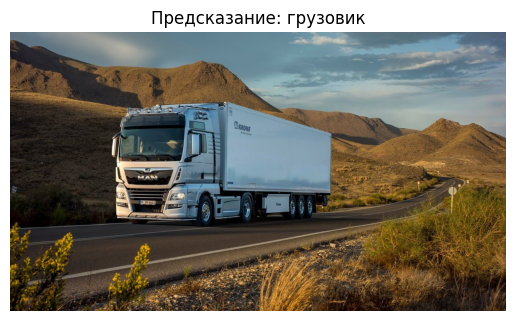

In [123]:

from torchvision import transforms

# Определение трансформаций для тестовых данных
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменяем размер изображения
    transforms.ToTensor(),         # Преобразуем в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])


from PIL import Image
import matplotlib.pyplot as plt

# Путь к случайному изображению
random_image_path = './gruz_sng.jpg' # Укажите путь к изображению

# Загрузка изображения
image = Image.open(random_image_path)

# Преобразование изображения
transformed_image = test_transforms(image).unsqueeze(0)  # Добавляем размер батча

# Перемещение на устройство (CPU/GPU)
transformed_image = transformed_image.to(device)

# Предсказание модели
pretrained_model.eval()  # Устанавливаем режим оценки
with torch.no_grad():
    output = pretrained_model(transformed_image)
    _, predicted_class = torch.max(output, 1)

# Получение имени класса
predicted_label = train_dataset.dataset.classes[predicted_class.item()]
# Вывод изображения и предсказания

plt.imshow(image)
plt.title(f"Предсказание: {predicted_label}")
plt.axis("off")
plt.show()


**Правильно ли модель классифицировала ваше изображение?** (макс. 10 баллов)

Ваш ответ: да 

**Какая итоговая точность работы вашей модели на тестовой выборке?** (макс. 10 баллов)

Ваш ответ: Fine-Tuning Test Accuracy: 85.00%

**Чем отличается прием извлечения признаков от дообучения?** (макс. 20 баллов)

Ваш ответ: Прием извлечения признаков подразумевает заморозку всех сверточных слоев модели и обучение только новой классификационной "головы". В дообучении, напротив, размораживаются некоторые или все слои модели, чтобы они могли адаптироваться к новому датасету. Дообучение позволяет модели "подстроиться" под специфические особенности новых данных, но требует больше ресурсов и осторожности, чтобы избежать переобучения.